Andrey_Bondarchuk_stepik_id_346032105

collab 

https://colab.research.google.com/drive/17Z03UnmxlCCZFzjRa-CU1NeZYPM9gVhq?usp=sharing

<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:

1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:

Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("/content/gdrive/MyDrive/data/image_codes.npy") 
captions = json.load(open('/content/gdrive/MyDrive/data/captions_tokenized.json'))

In [ ]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


In [ ]:
img_codes.shape

(118287, 2048)

Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [ ]:
import random
import torch
import nltk
import pandas as pd
import time

In [ ]:
from torch.utils.data import Dataset, random_split 

In [ ]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [ ]:
from torch.utils.data import DataLoader
import math

In [ ]:
import re

In [ ]:
random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)
torch.cuda.random.manual_seed(42)
torch.cuda.random.manual_seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### EDA распределение длины предложений в нашем датасэте

#### Соберем словарь

In [ ]:
tokenizer = nltk.WordPunctTokenizer()

In [ ]:
# начало предложения
SOS = '<sos>'
# конец предложения
EOS = '<eos>'
# паддинг
PAD = '<pad>'
# неизвестное слово
UNK = '<unk>'

In [ ]:
%%time
min_frequency = 2
sentеnses_length = []
words={}
for i in range(len(captions)):
    for sent in captions[i]:
        sent = sent.replace('.','')
        sent = re.sub(r"[^a-zA-Z]+", " ", sent)
        tokens = tokenizer.tokenize(sent.lower());
        sentеnses_length.append(len(tokens))
        for token in tokens:
            if token in words.keys():
                words[token] += 1
            else:
                words[token] = 1 
words_filfered = dict(filter(lambda item: item[1] > min_frequency, words.items()))
words = sorted(words_filfered, key=words_filfered.get)
words = sorted(words)
words.insert(0, PAD)      
words.insert(1, SOS)
words.insert(2, EOS)
words.insert(3, UNK)

CPU times: user 5.98 s, sys: 22.6 ms, total: 6 s
Wall time: 6 s


#### Средняя длина предложения, максимум и минимум.

In [ ]:
# средняя длина
np.mean(sentеnses_length)

10.475658356370522

In [ ]:
# максимум длины
np.max(sentеnses_length)

50

In [ ]:
# 0.5 квантиль
np.quantile(sentеnses_length, 0.5)

10.0

In [ ]:
# 0.95 квантиль
np.quantile(sentеnses_length, 0.99)

19.0

#### Гистограмма длин предложений.

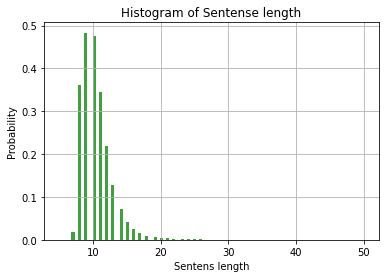

In [ ]:
# the histogram of the data
n, bins, patches = plt.hist(sentеnses_length, 100, density=True, facecolor='g', alpha=0.75)

plt.xlabel('Sentens length')
plt.ylabel('Probability')
plt.title('Histogram of Sentense length')
#plt.xlim(0, 100)
#plt.ylim(0, 0.5)
plt.grid(True)
plt.show()

**Вывод: Исходя из анализа длин предложений, а именно 0.99 квантиля который равен 20 токенам, будем обрезать предложения более 20 токенов, а короткие, которые менее 20 токенов, добивать до 20 токеном PAD.**

### Проектирование Class для Датасета

Class спроектирован единым образом для базовой и вариативной части проектов. vectors_8x8 - в базовой части проекта будет 'пустым' тензором

In [ ]:
class CaptionsDataset():
    def __init__(self, vectors_neck, captions, min_frequency = 1):
        
        self.tokenizer = nltk.WordPunctTokenizer()
        
        #self.vectors_8x8 =  vectors_8x8
        self.vectors_neck =  vectors_neck
        self.captions = captions
        
        # порог частоты вхождения в словарь
        self.min_frequency = min_frequency
        # максимальная длина предложения
        self.SENTENSE_LENGTH = 20
        # токен начало предложения
        self.SOS = '<sos>'
        # токен конец предложения
        self.EOS = '<eos>'
        # токен паддинг
        self.PAD = '<pad>'
        # токен неизвестное слово
        self.UNK = '<unk>'

        self.words = self.get_words()

        self.words_to_index = {self.words[i]: i for i in range(len(self.words))}
        self.index_to_words = {i: self.words[i] for i in range(len(self.words))}
    
    def __getitem__(self, item):
        # индекс для выбора случайного предложения для captions
        sent_idx = random.randint(0, len(self.captions[item])-1);
        text = self.captions[item][sent_idx]
        text = text.replace("<start>", "").replace('<end>','').replace('.','')
        text = re.sub(r"[^a-zA-Z]+", " ", text)
        
        vectors_neck = self.vectors_neck[item]
        vectors_8x8 = torch.ones(1); #self.vectors_8x8[item]

        tokens = self.get_tokens_(text)
        tokens = list(map(lambda x : x if x in self.words else self.UNK, tokens))
        
        # <sos> в начало
        tokens.insert(0, self.SOS)
        # обрезаем до 20 токенов
        tokens = tokens[:self.SENTENSE_LENGTH-1]
        sequence_length = len(tokens) + 1
        # добиваем паддингами если строка короче
        if len(tokens) < self.SENTENSE_LENGTH + 1:
            tokens.append(self.EOS)
            tokens += [self.PAD] * (self.SENTENSE_LENGTH - len(tokens))
        else:
            tokens = tokens[:self.SENTENSE_LENGTH - 1]
            tokens.append(self.EOS)            
          
        captions_ix = list(map(lambda x : self.words_to_index[x], tokens))
 
        return {'vectors_8x8': vectors_8x8, 
                'vectors_neck': vectors_neck, 
                'captions_ix': torch.LongTensor(captions_ix), 
                'sequence_length':sequence_length,
                'tokens':tokens, 
                'text':text}

    def get_tokens_(self, text):
        tokens = self.tokenizer.tokenize(text.lower())
        return tokens

    def get_words(self):      
        words={}
        for i in range(len(self.captions)):
            for sent in self.captions[i]:
                sent = sent.replace("<start>", "").replace('<end>','').replace('.','')
                sent = re.sub(r"[^a-zA-Z]+", " ", sent)
                tokens = self.tokenizer.tokenize(sent.lower());
                for token in tokens:
                    if token in words.keys():
                        words[token] += 1
                    else:
                        words[token] = 1   

        words_filfered = dict(filter(lambda item: item[1] > self.min_frequency, words.items()))
        words = sorted(words_filfered, key=words_filfered.get)
        words = sorted(words)
        words.insert(0, self.PAD)      
        words.insert(1, self.SOS)
        words.insert(2, self.EOS)
        words.insert(3, self.UNK)
        return words

    def __len__(self):
        return len(self.captions)

In [ ]:
data = CaptionsDataset(img_codes, captions, 2)

### Распределение на test и val выборку

In [ ]:
BATCH_SIZE = 64

In [ ]:
%%time
num_workers = 0 # было 2, но полезли проблемы.... 

train_size = math.ceil(len(data) * 0.9)

train, valid = random_split(data, [train_size, len(data) - train_size])

train = sorted(train, key=lambda x: x['sequence_length'])
#valid = sorted(valid, key=lambda x: x['sequence_length'])

train_loader = DataLoader(train, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=False, drop_last=True) 
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=False, drop_last=False)

CPU times: user 2min 13s, sys: 1.92 s, total: 2min 15s
Wall time: 2min 17s


Посмотрим что собрали, на примере одного экземпляра.

In [ ]:
batch_1 = next(iter(train_loader))

In [ ]:
print(batch_1['captions_ix'][0:5])

tensor([[    1,  8189, 10428,  3430,     4,  5348,     2,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    1,  6896,  6272,  3702, 11627,  7209, 12579,     2,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    1, 11620,  2187,  9031,   301,  7330, 10504,     2,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    1,  4765,  4963,  5648, 11560,  7634,  9620,     2,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    1,  1064,   422, 10182,  5648,     4,  4141,     2,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])


In [ ]:
batch_1['captions_ix'].shape

torch.Size([64, 20])

In [ ]:
print(batch_1['text'][0:5])

['person snowboarding down a hill ', ' men leading elephants through moving water ', 'three clocks reading and near someone ', ' giraffes grazing in the open savannah', 'birds are sitting in a field ']


In [ ]:
batch_1['vectors_neck']

tensor([[0.3041, 0.1589, 0.6654,  ..., 0.0382, 1.1643, 0.3033],
        [0.2264, 0.1949, 0.2904,  ..., 0.0704, 1.0805, 0.5983],
        [0.1232, 0.4127, 0.0892,  ..., 0.7430, 0.3187, 0.0327],
        ...,
        [0.0529, 0.7274, 0.1817,  ..., 0.1169, 0.1061, 0.1676],
        [0.6102, 0.0652, 0.1801,  ..., 0.2479, 0.2488, 0.5218],
        [0.1509, 0.1341, 1.4166,  ..., 0.9096, 0.7132, 0.1444]])

In [ ]:
batch_1['vectors_neck'].shape

torch.Size([64, 2048])

In [ ]:
batch_1['vectors_8x8'].shape

torch.Size([64, 1])

In [ ]:
batch_1['sequence_length']

tensor([7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

**Вывод: Данные для подачи в сеть - подготовлены.**

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class CaptionNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, cnn_feature_size=2048, dropout=0.5, num_layers=1, bidirectional = False):  
        super(self.__class__, self).__init__()
        #super(CaptionNet, self).__init__()

        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        # 2. слой эмбедднга
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        # 4. линейный слой для получения логитов
        
        self.cnn_feature_size = cnn_feature_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.D = D = 1 + bidirectional
        
        self.init_h = nn.Linear(cnn_feature_size, hidden_dim)  # линейный слой для hidden state для LSTM
        self.init_c = nn.Linear(cnn_feature_size, hidden_dim)  # линейный слой для cell state для LSTM
 
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional = bidirectional, bias=True, batch_first = True)  # LSTM

        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # слой эмбеддингов для оgисаний
        self.dropout = nn.Dropout(p=dropout)
        self.logit = nn.Linear(hidden_dim, vocab_size)


    def initializing_hidden_state(self, vectors_neck):
        # 1. инициализируем LSTM state
        list_h = []
        list_c = []        
        for i in range(self.num_layers*self.D):
            list_h.append(self.init_h(vectors_neck))  
            list_c.append(self.init_c(vectors_neck))        
        hidden =  torch.stack(list_h) 
        cell =  torch.stack(list_c)
        return hidden, cell
    
       
    def forward(self, vectors_8x8, vectors_neck, captions_ix):
        """ 
        Apply the network in training mode.
        :param vectors_8x8: torch tensor котрый будет использован для реализации attension
        :param vectors_neck: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """
        
        # 1. инициализируем LSTM state
        # H0 и С0 инициализируются в отдельной процедуре -> initializing_hidden_state(vectors_neck)
        hidden, cell  = self.initializing_hidden_state(vectors_neck)
              
        # 2. применим слой эмбеддингов к captions_ix
        captions_emb = self.dropout(self.embedding(captions_ix)) 
        #print(captions_emb.shape) 

        # 3. скормим LSTM captions_emb    
        output, (hidden, cell) = self.lstm(captions_emb, (hidden, cell))

        # 4. посчитаем логиты из выхода LSTM
        logits = self.logit(output)
        
        return logits, hidden, cell
     

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
VOCAB_SIZE = len(data.words)
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
NUM_LAYERS = 1
DROPOUT = 0.5

In [ ]:
VOCAB_SIZE

13035

In [ ]:
network = CaptionNet(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, cnn_feature_size = 2048, dropout=DROPOUT, num_layers=NUM_LAYERS)

In [ ]:
network.to(device)

CaptionNet(
  (init_h): Linear(in_features=2048, out_features=256, bias=True)
  (init_c): Linear(in_features=2048, out_features=256, bias=True)
  (lstm): LSTM(256, 256, batch_first=True)
  (embedding): Embedding(13035, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (logit): Linear(in_features=256, out_features=13035, bias=True)
)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
network.apply(init_weights)        

CaptionNet(
  (init_h): Linear(in_features=2048, out_features=256, bias=True)
  (init_c): Linear(in_features=2048, out_features=256, bias=True)
  (lstm): LSTM(256, 256, batch_first=True)
  (embedding): Embedding(13035, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (logit): Linear(in_features=256, out_features=13035, bias=True)
)

In [ ]:
# индекс паддинга
PAD_IDX = data.words_to_index[data.PAD]

In [ ]:
optimizer = optim.Adam(network.parameters(), lr=4e-4)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX).to(device)
CLIP = 5

to do

``` python

def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова. 
    # 1. Получаем логиты, прогоняя image_vectors через сеть
    # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
    # вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!
    
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    
    loss = <YOUR CODE>
    
    return loss

````

### Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [ ]:
# единая процедура для базовой и вариационной части проекта
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):   
    
    model.train()

    epoch_loss = 0
    history = []

    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()

        # vectors_8x8 - в базовой части проекта не используется 
        vectors_8x8  = batch['vectors_8x8'].to(device)
        # vectors_neck == image_vectors   
        vectors_neck = batch['vectors_neck'].to(device)        
        captions_ix = batch['captions_ix'].to(device)
        sequence_length = batch['sequence_length']

        maxlen = max(sequence_length).item()
  
        logits, hidden, cell = model(vectors_8x8, vectors_neck, captions_ix)
  
        preds = logits[:,:(maxlen-1),:]
        preds = preds.reshape(preds.shape[0]*preds.shape[1], preds.shape[2])
        
        # сдвигаем на токен вперед
        targets = captions_ix[:, 1:maxlen]
        targets = targets.reshape(targets.shape[0]*targets.shape[1])

        softmax = F.log_softmax(logits, -1)
        #get the highest predicted token from our predictions
        top_token = torch.argmax(softmax, -1)
        top_token = top_token[:, :maxlen]

        loss = criterion(preds, targets)

        loss.backward()
            
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        # очищаем cuda ---------------------------------------------------------
        if True:
            try:
                
                logits.to(torch.device('cpu'))
                hidden.to(torch.device('cpu'))
                cell.to(torch.device('cpu')), 
                vectors_8x8.to(torch.device('cpu'))                
                vectors_neck.to(torch.device('cpu'))
                captions_ix.to(torch.device('cpu'))
                preds.to(torch.device('cpu'))
                targets.to(torch.device('cpu'))
                softmax.to(torch.device('cpu'))
                
                del logits, hidden, cell, logits, vectors_8x8, vectors_neck, captions_ix, preds, targets, softmax
                
                torch.cuda.empty_cache()
            except:
                pass    
        # =---------------------------------------------------------------------
        
        history.append(loss.cpu().data.numpy())
        
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            # vectors_8x8 - в базовой части проекта не используется 
            vectors_8x8  = batch['vectors_8x8'].to(device)
            # vectors_neck == image_vectors   
            vectors_neck = batch['vectors_neck'].to(device)        
            captions_ix = batch['captions_ix'].to(device)
            sequence_length = batch['sequence_length']

            maxlen = max(sequence_length).item()
      
            logits, hidden, cell = model(vectors_8x8, vectors_neck, captions_ix)
      
            preds = logits[:,:(maxlen-1),:]
            preds = preds.reshape(preds.shape[0]*preds.shape[1], preds.shape[2])
            
            # сдвигаем на токен вперед
            targets = captions_ix[:, 1:maxlen]
            targets = targets.reshape(targets.shape[0]*targets.shape[1])

            softmax = F.log_softmax(logits, -1)
            #get the highest predicted token from our predictions
            top_token = torch.argmax(softmax, -1)
            top_token = top_token[:, :maxlen]

            loss = criterion(preds, targets)

            epoch_loss += loss.item()

            # очищаем cuda ---------------------------------------------------------
            if True:
                try:
                    
                    logits.to(torch.device('cpu'))
                    hidden.to(torch.device('cpu'))
                    cell.to(torch.device('cpu')), 
                    vectors_8x8.to(torch.device('cpu'))                
                    vectors_neck.to(torch.device('cpu'))
                    captions_ix.to(torch.device('cpu'))
                    preds.to(torch.device('cpu'))
                    targets.to(torch.device('cpu'))
                    softmax.to(torch.device('cpu'))
                    
                    del logits, hidden, cell, logits, vectors_8x8, vectors_neck, captions_ix, preds, targets, softmax
                    
                    torch.cuda.empty_cache()
                except:
                    pass    
            # =---------------------------------------------------------------------
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

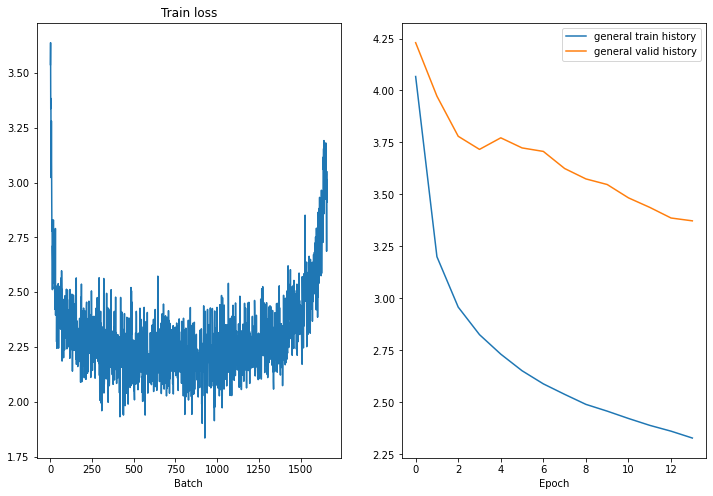

Epoch: 15 | Time: 3m 12s
	Train Loss: 2.301 | Train PPL:   9.987
	 Val. Loss: 3.345 |  Val. PPL:  28.355
CPU times: user 47min 12s, sys: 54.6 s, total: 48min 7s
Wall time: 48min 31s


In [ ]:
%%time

train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 5

teacher_forcing_ratio = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()

    train_loss = train(network, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(network, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(network.state_dict(), '/content/gdrive/MyDrive/best_simple_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
print('All Done!')

All Done!


#### Расчет bleu на val

In [ ]:
model = CaptionNet(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, cnn_feature_size=2048, dropout=DROPOUT, num_layers=NUM_LAYERS)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/best_simple_model.pt', map_location=torch.device(device)))
model.to(device)

CaptionNet(
  (init_h): Linear(in_features=2048, out_features=256, bias=True)
  (init_c): Linear(in_features=2048, out_features=256, bias=True)
  (lstm): LSTM(256, 256, batch_first=True)
  (embedding): Embedding(13035, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (logit): Linear(in_features=256, out_features=13035, bias=True)
)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

In [ ]:
def cut_on_eos(tokens_iter):
    for token in tokens_iter:
        if token == '<eos>':
            break
        yield token

def remove_tech_tokens(tokens_iter, tokens_to_remove=['<sos>', '<unk>', '<pad>']):
    return [x for x in tokens_iter if x not in tokens_to_remove]

In [ ]:
model.eval()
    
original_text = []
generated_text = []

with torch.no_grad():
    
    for i, batch in enumerate(valid_loader):

        # vectors_8x8 - в базовой части проекта не используется 
        vectors_8x8  = batch['vectors_8x8'].to(device)
        # vectors_neck == image_vectors   
        vectors_neck = batch['vectors_neck'].to(device)        
        captions_ix = batch['captions_ix'].to(device)
        sequence_length = batch['sequence_length']

        maxlen = max(sequence_length).item()

        batch_size = batch['vectors_neck'].shape[0]
  
        logits, hidden, cell = model(vectors_8x8, vectors_neck, captions_ix)
  
        preds = logits[:,:(maxlen-1),:]
        preds = preds.reshape(preds.shape[0]*preds.shape[1], preds.shape[2])
        
        # сдвигаем на токен вперед
        targets = captions_ix[:, 1:maxlen]
        targets = targets.reshape(targets.shape[0]*targets.shape[1])

        softmax = F.log_softmax(logits, -1)
        #get the highest predicted token from our predictions
        top_token = torch.argmax(softmax, -1)
        top_token = top_token[:, :maxlen]
 
        for _j in range(1,batch_size):
           sentence = cut_on_eos([data.index_to_words[x] for x in list(captions_ix[_j].cpu().numpy())])
           sentence = remove_tech_tokens(sentence)
           original_text.append(sentence)  
       
        for _j in range(1, batch_size):
            tokenlist = list(top_token[_j].cpu().numpy())
            tokenlist = tokenlist[:sequence_length[_j]]
            sentence = cut_on_eos([data.index_to_words[x] for x in tokenlist])
            sentence = remove_tech_tokens(sentence)
            generated_text.append(sentence)

        # очищаем cuda ---------------------------------------------------------
        if True:
            try:                
                logits.to(torch.device('cpu'))
                hidden.to(torch.device('cpu'))
                cell.to(torch.device('cpu')), 
                vectors_neck.to(torch.device('cpu'))
                vectors_8x8.to(torch.device('cpu'))
                captions_ix.to(torch.device('cpu'))
                preds.to(torch.device('cpu'))
                targets.to(torch.device('cpu'))
                softmax.to(torch.device('cpu'))
                
                del logits, hidden, cell, logits, vectors_8x8, vectors_neck, captions_ix, preds, targets,softmax

                torch.cuda.empty_cache()
            except:
                pass    
        # =---------------------------------------------------------------------
        #break

Посмотрим на оригинальный и сгенерированный тексты.

In [ ]:
for i in range(15):
    
    # случайный индекс
    random_i = random.randint(0, len(original_text))

    print('Original: {}'.format(' '.join(original_text[random_i])))
    print('Generated: {}'.format(' '.join(generated_text[random_i])))
    print()

Original: a woman standing on a street corner under a traffic signal
Generated: a street is in a sidewalk corner with a sign sign with and

Original: a bathroom sink with lots of lights above it
Generated: a bathroom with with a of sinks and it and a

Original: three young girls talk while under the umbrella
Generated: a women girls holding to holding a umbrella and and

Original: a train on a train track near many other tracks
Generated: a train is a track track with a cars cars with in

Original: two giraffe snuggling next to each other in a field
Generated: a giraffes standing with to each other in a field with with

Original: a woman holding onto a beer and some food
Generated: a man in a a wii while a food in while

Original: a big soft kitty on top of a bed next to a laptop computer
Generated: a cat cat cat cat a of a cat with to a cat and and on

Original: a man at a restaurant eating a large plate of fried chicken
Generated: a man sitting a table table a meal sandwich of food f

In [ ]:
hypotheses = [text for text in generated_text]
list_of_references = [[text] for text in original_text]

In [ ]:
chencherry = SmoothingFunction()
bleu = corpus_bleu(list_of_references, hypotheses,  smoothing_function=chencherry.method7)*100
print('BLEU {}'.format(round(bleu,2)))

BLEU 16.96


Вывод: По-видимому, следовало бы поучить подольше и увеличить количество эпох. Так как наша сетка любит "заикаться". Но, к сожалению, бесплатный collab ограничивает время на GPU 2-3 часами в день.....

### Inseption и получение результатов


загружаем веса лучшей модели.

In [ ]:
network = CaptionNet(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, cnn_feature_size= 2048, dropout=DROPOUT, num_layers=NUM_LAYERS)
network.load_state_dict(torch.load('/content/gdrive/MyDrive/best_simple_model.pt', map_location=torch.device(device)))
network.to(device)

CaptionNet(
  (init_h): Linear(in_features=2048, out_features=256, bias=True)
  (init_c): Linear(in_features=2048, out_features=256, bias=True)
  (lstm): LSTM(256, 256, batch_first=True)
  (embedding): Embedding(13035, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (logit): Linear(in_features=256, out_features=13035, bias=True)
)

Подгрузим Inseption

In [ ]:
from torchvision.models.inception import Inception3
from warnings import warn


class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    
from torch.utils.model_zoo import load_url

def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [ ]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
# from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:47: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

#### Сгенерируем описание

In [ ]:
# индекс начала предложения
SOS_IDX = data.words_to_index[data.SOS]

In [ ]:
# индекс конца предложения
EOS_IDX = data.words_to_index[data.EOS]

In [ ]:
def generate_caption(model, image, caption_prefix=(SOS_IDX,), t=5, sample=True, max_len=25):

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
     
    with torch.no_grad():
        
        image_tensor = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
        vectors_8x8, vectors_neck, logits = inception(image_tensor[None])        
        vectors_neck = vectors_neck.to(device) 

        caption_prefix = list(caption_prefix)
        input = torch.tensor(caption_prefix).reshape(1,1)
        input = input.to(device)          
  
        # слово за словом генерируем описание картинки
        for j in range(max_len):
             
            # -------------------------------------------------------------------------------------------------------------
            # 1. представляем caption_prefix в виде матрицы
            # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
            # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
            # 4. сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
            # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
            # 5. Добавляем новое слово в caption_prefix
            # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся
            # -------------------------------------------------------------------------------------------------------------
            
            logits, hidden, cell = model(vectors_8x8, vectors_neck, input)
            predictions = F.softmax(logits, -1)
            
            if not sample:
                # жадное сэмплирование -----------------------------------------
                outputs = torch.argmax(predictions, -1)
                # --------------------------------------------------------------
            else:
                # сэмплирование из распределения -------------------------------

                # список индексов из t наиболее вероятных токенов 
                list_ind = torch.argsort(predictions, dim=-1, descending=True).squeeze(0)[-1,:][0:t].tolist()
                # вероятности t токенов в распределении в полном словаре
                prob = predictions[0,0,list_ind]
                # нормируем на 1 вероятности списка из t токенов
                prob_norm = F.softmax(prob, -1).tolist()
                # сэмплируем один токен из списка t токенов
                outputs = random.choices(list_ind, weights=prob_norm, k=1)[0]
                outputs = torch.tensor(outputs).unsqueeze(0).unsqueeze(0)
                # --------------------------------------------------------------

            sample_token = outputs[0,-1]
            if sample_token.item() == EOS_IDX:
                break
            input = torch.cat([input, sample_token.unsqueeze(0).unsqueeze(0)], dim=1)
            
        sentence = cut_on_eos([data.index_to_words[x] for x in input[0].cpu().tolist()])
        sentence = remove_tech_tokens(sentence)
        sentence = ' '.join(sentence)

    #print(sentence)
    return sentence

#### Скачаем пару картинок, чтобы проверить качество:

In [ ]:
#!pip install scipy

In [ ]:
from matplotlib import pyplot as plt
#from scipy.misc import imresize
from skimage.transform import resize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img_skate.jpg
img_skate = plt.imread('img_skate.jpg')
#img = imresize(img, (299, 299)).astype('float32') / 255.
img_skate = resize(img_skate, (299, 299, 3)).astype('float32') #/255.



--2022-07-17 06:33:24--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2022-07-17 06:33:24--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img_skate.jpg’

img_skate.jpg       100%[===================>]  53.45K  --.-KB/s    in 0.003s  

2022-07-17 06:33:24 (15.1 MB/s) - ‘img_skate.jpg’ 

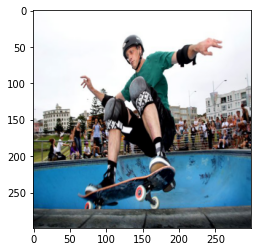

In [ ]:
plt.imshow(img_skate)

In [ ]:
for i in range(10):
    print(generate_caption(network, img_skate, t=5, sample=True ))

a man jumping in mid park while holding a frisbee as she is sitting in the middle the ground watching something on
a person with the back and his skateboard jumping in mid mid mid flight of a concrete area in it
two boys with one foot on skateboard on skateboard doing his way up a ramp at
a person is doing the skateboard trick on a skateboard with a person on it s foot
man in white jeans and white jeans and a hat is jumping in his hand at his skateboarding outdoors watching outside
an athlete jumps into air on a snowboard while another man jumps to a ball while a dog
a boy jumping on his feet in a blue park with a snowboard over a concrete side railing side
a young person jumping on a board in his skate board on a skateboard at a man
two people in a black skateboard doing the sky while he performs the side in his skate boarding ramp outside area watching area players nearby
an airborne man doing a skateboard jump on a railing on a skateboard on the ground and holding a bat nearby nearb

In [ ]:
for i in range(10):
    print(generate_caption(network, img_skate, t=5, sample=False ))

a man in a skate board doing a trick on a skateboard in the air on a ramp
a man in a skate board doing a trick on a skateboard in front of a ramp
a man in a blue shirt and jeans doing a trick on a skateboard in the air
a man in a blue shirt is jumping over his skateboard while he is in the air
a man in a blue shirt is jumping over a skateboard while another man is skateboarding in the
a man in a skateboard performing a trick on a skate board in a skate park
a man in a skate board doing a trick on a skateboard in a skate park
a man in a skate board doing a trick on a skateboard in front of a skate park
a man in a blue shirt and jeans on a skateboard doing a trick in a skate park
a man in a skate board doing a trick on a skateboard in a skate park


--2022-07-17 07:09:51--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2022-07-17 07:09:52--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img_cat_and_dog.jpg’

img_cat_and_dog.jpg 100%[===================>] 104.37K   268KB/s    in 0.4s    

2022-07-17 07:09:53 (268 KB/s) - ‘img_cat_and_dog.jpg’ saved [106870/106870]



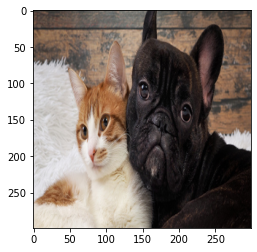

an image taken a man and cat in a chair and a brown chair and a white
two black cat sitting on the floor next to each another in an office in an open area
two small brown cats standing under one is on the ground while another is wearing his shirt
two small brown dog wearing a black collar standing by side by side with its head of them cat
this dog has an open face and his tongue out is standing up on a leash on a bed chair and pillow on seat holding
the cat was curled in front with its tongue out in front with her cat on the side
the dog are laying next for each other on and a chair with his eyes and a sleeping cat sleeping
a cat standing under a blue cat on its hind head and a dog in front to the cat s seat
this cat looks in a cat and its neck up with a cat standing in front door of something
the two white and a white and a brown dog sits by two brown dogs on top of a


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img_cat_and_dog.jpg
img_cat_and_dog = plt.imread('img_cat_and_dog.jpg')
#img = imresize(img, (299, 299)).astype('float32') / 255.
img_cat_and_dog = resize(img_cat_and_dog, (299, 299, 3)).astype('float32')

plt.imshow(img_cat_and_dog)
plt.show()

for i in range(10):
    print(generate_caption(network, img_cat_and_dog, t=5, sample = True))

### Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

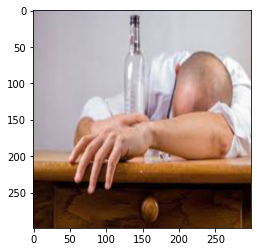

a young boy in a green suit with glasses sits at an orange laptop with an iphone and orange
a woman wearing white jeans and glasses holding up the two white and a cup on a plate on a bench and chair on
an adorable dog sits in the top with a cup on the ground and looking out the front door outside food and smiling bear in
there a man sitting on the top is in a white sweater with her hands out on
a young boy in black sweater is sitting and a woman holding a cup next tot him and a ball bottle in hand on him
there image the image shows two children and a girl in front with the same open on a microwave bottle
an asian girl in the air and holding a donut with two cups and the same candle and drinks
two girls sitting next one a book with two cups with other dogs on top in it with her head
the person are wearing sunglasses and one of the top and one holds a white shirt in his shirt
two young girls sitting around one side and a man on the top and holding a remote in hand on it hand nearby and f

In [ ]:
img = plt.imread('drink.jpg')
img = resize(img, (299, 299, 3)).astype('float32')

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(network, img, t=5, sample = True))

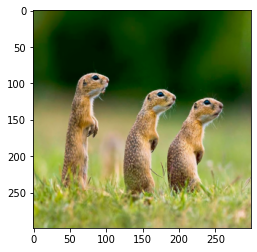

a woman holding two teddy animal on her legs as she stands near some bushes with flowers side nearby and food on it s back
a pair black and white photo on the bottom in a wooded setting while wearing sunglasses
this is no a black bear sits with the legs of his as they ride a horse
a black cat sits with a basket that appears like the other to a person on
two different are dressed one sitting on the ground next tot another man and holding her ski
three different birds sitting in a tree lined in the shape and a bottle on the other
three white image shows two men with a pair of them in front on a pair a horse behind
a person sitting next toa with his legs in her hand as it holds her ear
two white birds on top of a white and blue cloth in a body in front od
three different sized containers that have a bunch with fruit and a pile sitting next to him


In [ ]:
img = plt.imread('suslik.jpg')
img = resize(img, (299, 299, 3)).astype('float32')

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(network, img, t=5, sample = True))

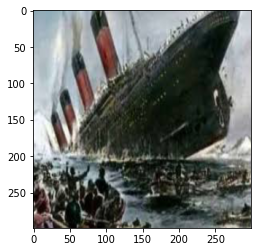

two people are looking up in an ocean with a large child standing near an airplane and water in it hand in
there are many small birds standing around on their backs in their hand on a rocky shore area
there looks a man that is a picture on the water in an empty body of water area with water nearby watching in hand watching
a person riding an airplane while a man on a board while another person watches the water
an image is riding the water as he is on board on his knees and the boat is the wind is eating
there are an old photo taken in a boat and a man in a large brown raft in the
the large motorboat is parked and water in a calm area of water as another person is on the shore
the man and a child are walking down on their surf boat with people and boats and water in
a man on the side the water and the ocean with a man on top and riding the back
a boat is standing at some sand with the ocean in them in a calm air over water in the distance in background and flying


In [ ]:
img = plt.imread('titanik.jpg')
img = resize(img, (299, 299, 3)).astype('float32')

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(network, img, t=5, sample = True))

## Итоги baseline

- не без труда, но нам удалось сконструировать рабочую модель для генерации подписей к картинкам. 

- несмотря на ограничения которые накладывает бесплатный коллаб на вычислительные ресурсы удалось добиться приемлемого качества модели, что видно, например, для последней картинки с титаником. 

- в варианте с "семплированием из распределения" модель отличается повышенной 'разговорчивостью' и ее приходиться ограничивать максимальной длиной предложения)))))

## Вариативная часть:

**Бонус: Achtung**

В качестве бонусного задания попытаемся реализовать  механизм attention в rnn-сети, которую мы писали в базовой части.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Все импорты в одном месте

In [2]:
import random
import nltk
import pandas as pd
import time

import numpy as np
import json

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from tqdm import tqdm

In [5]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [6]:
from skimage.transform import resize

In [7]:
import re

In [8]:
from torch.utils.data import Dataset, random_split

In [9]:
from torch.utils.data import DataLoader
import math

In [10]:
import collections
import os
from PIL import Image

In [11]:
random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)
torch.cuda.random.manual_seed(42)
torch.cuda.random.manual_seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Подготовка датасета

Для подготовки датасета воспользуемся частитчно идеями из ноутбука

https://www.tensorflow.org/tutorials/text/image_captioning

#### Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train your model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [ ]:
import tensorflow as tf

In [ ]:
if True:

    # Download caption annotation files
    annotation_folder = '/annotations/'
    if not os.path.exists(os.path.abspath('.') + annotation_folder):
        annotation_zip = tf.keras.utils.get_file('captions.zip',
                                               cache_subdir=os.path.abspath('.'),
                                               origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                               extract=True)
        annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
        os.remove(annotation_zip)

    # Download image files
    image_folder = '/train2014/'
    if not os.path.exists(os.path.abspath('.') + image_folder):
        image_zip = tf.keras.utils.get_file('train2014.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin='http://images.cocodataset.org/zips/train2014.zip',
                                          extract=True)
        PATH = os.path.dirname(image_zip) + image_folder
        os.remove(image_zip)
    else:
        PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 218s 0us/step


#### Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train your model. Choosing to use more data would result in improved captioning quality.

In [ ]:
LIMIT_SIZE = 6000

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())

random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:LIMIT_SIZE]
print(len(train_image_paths))

6000


In [ ]:
image_path = train_image_paths[1]
captions = image_path_to_caption[image_path]
    
img = plt.imread(image_path)
img = resize(img, (299, 299, 3)).astype('float32')

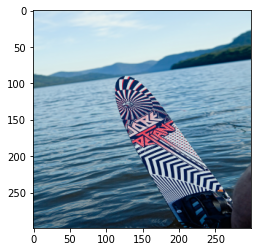

In [ ]:
plt.imshow(img)

In [ ]:
captions

['<start> A man riding a snowboard on snow covered ground. <end>',
 '<start> A man on a snowboard is watching the other people. <end>',
 '<start> Some snow skiers are by a large mountain. <end>',
 '<start> a person riding a snow board on a snowy surface  <end>',
 '<start> A man who is standing on a snowboard in the snow. <end>']

In [ ]:
from torchvision.models.inception import Inception3
from warnings import warn

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    
from torch.utils.model_zoo import load_url
def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
#from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:47: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


In [ ]:
%%time
captions_dict = {}
with open('/content/drive/MyDrive/vectors.npy', 'wb') as f:    
    with torch.no_grad():
        for i in tqdm(range(LIMIT_SIZE)):
            image_path = train_image_paths[i]
            captions_dict[i] = image_path_to_caption[image_path]
            img = plt.imread(image_path)
            img = resize(img, (299, 299, 3)).astype('float32')
            
            # подаем картинку в inception
            image_tensor = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32)
            vectors_8x8, vectors_neck, logits = inception(image_tensor[None])
            
            # тензора пишем последовательно сразу в файл
            np.save(f, vectors_neck)        
            np.save(f, vectors_8x8)        


100%|██████████| 6000/6000 [43:37<00:00,  2.29it/s]

CPU times: user 42min 54s, sys: 10min 39s, total: 53min 33s
Wall time: 43min 37s


In [ ]:
with open("/content/drive/MyDrive/captions.json", "w") as outfile:
    json.dump(captions_dict, outfile)

In [ ]:
print('all Done!')

all Done!


#### Проверим загрузку из файлов

В результате работы были сформированы два файла

- vectors.npy https://drive.google.com/file/d/1-0B3CqGFDs8Q-8RiaOBJ98yDJA_XdDGi/view?usp=sharing

- captions.json https://drive.google.com/file/d/1-AMTjNtRIe5K2PiYzVcA8Srwgz6mBAtT/view?usp=sharing

In [ ]:
# !pip install unrar
# !unrar x gdrive/MyDrive/vectors.rar

#### Captions

In [12]:
# загружаем описания
captions = json.load(open('/content/drive/MyDrive/captions.json'))

In [13]:
captions['0']

['<start> a glass desk area with two monitors, camera, keyboard and projector <end>',
 '<start> Two computer monitors are sitting side by side on the desk. <end>',
 '<start> Two computer monitors are set up on a desk. <end>',
 '<start> Two computer screens sitting on a desk or table. <end>',
 '<start> Two large computer monitors sit on a glass table. <end>']

In [14]:
captions['5999']

['<start> A room filled with beds and furniture with a window. <end>',
 '<start> A bed and two couches in front of french windows.  <end>',
 '<start> A white room with a bed with colorful bedding and red floral curtains and day-beds. <end>',
 '<start> A very large bedroom with brightly colored bedding and curtains. <end>',
 '<start> This hotel room has sofas that can be used as extra beds. <end>']

#### Эмбеддинги картинок

Загружаем в словари эмбеддинги

In [15]:
LIMIT_SIZE = 6000

dict_vectors_8x8 = {}
dict_vectors_neck = {}

with open('/content/drive/MyDrive/vectors.npy', 'rb') as f:
    for i in tqdm(range(LIMIT_SIZE)):
        vectors_neck = np.load(f)
        vectors_8x8 = np.load(f)
        dict_vectors_neck[i] = torch.Tensor(vectors_neck).squeeze(0)       
        dict_vectors_8x8[i] = torch.Tensor(vectors_8x8).squeeze(0).reshape(2048,64).permute(1,0)

100%|██████████| 6000/6000 [00:26<00:00, 226.59it/s]


Эмбеддинги записаны в два словаря размерностью 6000 элементов

In [16]:
dict_vectors_8x8[0].shape

torch.Size([64, 2048])

In [17]:
dict_vectors_neck[0].shape

torch.Size([2048])

#### Class для датасета

In [18]:
class CaptionsDataset6000():
    def __init__(self, vectors_8x8, vectors_neck, captions, min_frequency = 1):
        
        self.tokenizer = nltk.WordPunctTokenizer()
        
        self.vectors_8x8 =  vectors_8x8
        self.vectors_neck =  vectors_neck
        self.captions = captions
        
        # порог частоты вхождения в словарь
        self.min_frequency = min_frequency
        # максимальная длина предложения
        self.SENTENSE_LENGTH = 20
        # токен начало предложения
        self.SOS = '<sos>'
        # токен конец предложения
        self.EOS = '<eos>'
        # токен паддинг
        self.PAD = '<pad>'
        # токен неизвестное слово
        self.UNK = '<unk>'

        self.words = self.get_words()

        self.words_to_index = {self.words[i]: i for i in range(len(self.words))}
        self.index_to_words = {i: self.words[i] for i in range(len(self.words))}
    
    def __getitem__(self, item):
        # индекс для выбора случайного предложения для captions
        sent_idx = random.randint(0, len(self.captions[str(item)])-1);
        text = self.captions[str(item)][sent_idx]
        text = text.replace("<start>", "").replace('<end>','').replace('.','')
        text = re.sub(r"[^a-zA-Z]+", " ", text)
        
        vectors_neck = self.vectors_neck[item]
        vectors_8x8 = self.vectors_8x8[item]

        tokens = self.get_tokens_(text)
        tokens = list(map(lambda x : x if x in self.words else self.UNK, tokens))
        
        # <sos> в начало
        tokens.insert(0, self.SOS)
        # обрезаем до 20 токенов
        tokens = tokens[:self.SENTENSE_LENGTH-1]
        sequence_length = len(tokens) + 1
        # добиваем паддингами если строка короче
        if len(tokens) < self.SENTENSE_LENGTH + 1:
            tokens.append(self.EOS)
            tokens += [self.PAD] * (self.SENTENSE_LENGTH - len(tokens))
        else:
            tokens = tokens[:self.SENTENSE_LENGTH - 1]
            tokens.append(self.EOS)            
          
        captions_ix = list(map(lambda x : self.words_to_index[x], tokens))
 
        return {'vectors_8x8': vectors_8x8, 
                'vectors_neck': vectors_neck, 
                'captions_ix': torch.LongTensor(captions_ix), 
                'sequence_length':sequence_length,
                'tokens':tokens, 
                'text':text}

    def get_tokens_(self, text):
        tokens = self.tokenizer.tokenize(text.lower())
        return tokens

    def get_words(self):      
        words={}
        for i in range(len(self.captions)):
            for sent in self.captions[str(i)]:
                sent = sent.replace("<start>", "").replace('<end>','').replace('.','')
                sent = re.sub(r"[^a-zA-Z]+", " ", sent)
                tokens = self.tokenizer.tokenize(sent.lower());
                for token in tokens:
                    if token in words.keys():
                        words[token] += 1
                    else:
                        words[token] = 1   

        words_filfered = dict(filter(lambda item: item[1] > self.min_frequency, words.items()))
        words = sorted(words_filfered, key=words_filfered.get)
        words = sorted(words)
        words.insert(0, self.PAD)      
        words.insert(1, self.SOS)
        words.insert(2, self.EOS)
        words.insert(3, self.UNK)
        return words

    def __len__(self):
        return len(self.captions)

In [19]:
data = CaptionsDataset6000(dict_vectors_8x8, dict_vectors_neck, captions, 1)

In [20]:
data[5999]

{'captions_ix': tensor([   1,    4, 3318, 1464, 4542,  325,  100, 1642, 4542,    4, 4526,    2,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'sequence_length': 12,
 'text': ' A room filled with beds and furniture with a window ',
 'tokens': ['<sos>',
  'a',
  'room',
  'filled',
  'with',
  'beds',
  'and',
  'furniture',
  'with',
  'a',
  'window',
  '<eos>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 'vectors_8x8': tensor([[0.4641, 0.0000, 0.3538,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2751,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.3689, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 1.1667,  ..., 0.0000, 0.0000, 0.1033],
         [0.0000, 0.0000, 0.6469,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 'vectors_neck': tensor([0.2287, 0.0684, 0.7032,  ..., 0.1361, 0.2722, 0.3369])}

In [21]:
# размер словаря
len(data.words_to_index)


4613

### Распределение на test и val выборку в пропорции

In [22]:
BATCH_SIZE = 16

num_workers = 0 # 4 - для collab, 0 - local

train_size = math.ceil(len(data) * 0.95)

train, valid = random_split(data, [train_size, len(data) - train_size])

#train = sorted(train, key=lambda x: x['sequence_length'])
#valid = sorted(valid, key=lambda x: x['sequence_length'])

train_loader = DataLoader(train, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=False, drop_last=False)

Посмотрим, что собрали.

In [23]:
batch_1 = next(iter(train_loader))

In [24]:
print(batch_1['captions_ix'][0:5])

tensor([[   1,    4, 3665,  417, 4363, 4542, 3714, 1538, 2020,    2,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4, 2886, 2666,    4, 3686, 2086,   10, 4082, 3685,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   1, 4094, 3617,  115, 4142,  303, 2587, 4142, 4082, 3762,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   1, 4094,  134, 3472, 4609, 2666, 4082, 1165, 3289,    2,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   1, 4286, 2669, 4471, 3576, 3004, 1999, 2683, 1163,    2,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])


In [25]:
batch_1['vectors_8x8'].shape

torch.Size([16, 64, 2048])

In [26]:
batch_1['sequence_length']

tensor([10, 11, 11, 10, 10, 13, 14, 13, 11, 10, 12, 12, 10, 12, 12, 10])

In [27]:
max(batch_1['sequence_length'])

tensor(14)

### Собираем сетку RNN + Attension

#### Bahdanau’s Attention

Attension адаптируем из домашней работы по теме Seq2Seq.

In [28]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim, n_layers = 1, bidirectional = True):
        super().__init__()

        self.n_layers = n_layers
        self.enc_hidden_dim = enc_hidden_dim
        self.dec_hidden_dim = dec_hidden_dim
        self.D = D = 1 + bidirectional

        self.attn = nn.Linear(enc_hidden_dim  + self.D * n_layers * dec_hidden_dim, enc_hidden_dim)
        self.v = nn.Linear(enc_hidden_dim, 1, bias = False)
        
    def forward(self, hidden, vectors_8x8):
        
        # vectors_8x8 = [batch_size, 8*8, enc_hidden_dim] 
        # hidden = [D * n_layers, batch size, dec_hidden_dim] - декодер hidden

        hidden = hidden.permute(1,0,2)
        batch_size = vectors_8x8.shape[0]

        attn_features = vectors_8x8.shape[1] # = 8*8 

        hidden = hidden.reshape(batch_size, 1, (self.D * self.n_layers * self.dec_hidden_dim)).squeeze(1)
        # [batch_size, D * n_layers* dec_hidden_dim] 
        
        #repeat decoder hidden state 8*8 times
        hidden = hidden.repeat(attn_features, 1, 1).permute(1,0,2)
        
        # calculate energy
        #energy = [batch size, src_len, dec hid dim] 
        energy = torch.cat((hidden, vectors_8x8), dim = 2)
        # [batch_size, src_len, D * n_layers*dec_hidden_dim + enc_hidden_dim]
        energy = torch.tanh(self.attn(energy))
         
        # get attention, use softmax function 
        attention = self.v(energy).squeeze(2)
        # [batch_size, 8*8]

        attn_weights = torch.softmax(attention, dim=1)
        # [batch_size, 8*8]

        return attn_weights

#### Новая RNN сеть с блоком attension

In [30]:
class CaptionNetWithAttension(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, cnn_feature_size=2048, dropout=0.5, num_layers=1, bidirectional = True):  
        super(self.__class__, self).__init__()
        #super(CaptionNetWithAttension, self).__init__()
        
        self.cnn_feature_size = cnn_feature_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.D = D = 1 + bidirectional
        
        self.init_h = nn.Linear(cnn_feature_size, hidden_dim)  # линейный слой для hidden state для LSTM
        self.init_c = nn.Linear(cnn_feature_size, hidden_dim)  # линейный слой для cell state для LSTM
 
        self.lstm = nn.LSTM(embed_dim + cnn_feature_size, hidden_dim, dropout = 0.5, num_layers=num_layers, bidirectional = self.bidirectional,  bias=True, batch_first = True)  # LSTM

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # слой эмбеддингов для оgисаний
        self.dropout = nn.Dropout(p=dropout)
        
        #self.logit = nn.Linear(D * hidden_dim + embed_dim + cnn_feature_size, vocab_size)
        self.logit = nn.Linear(D * hidden_dim, vocab_size)

        self.attention = Attention(cnn_feature_size, hidden_dim, num_layers, bidirectional)

    def initializing_hidden_state(self, vectors_neck):
        # 1. инициализируем LSTM state
        list_h = []
        list_c = []
        for i in range(self.num_layers * self.D):
            list_h.append(self.init_h(vectors_neck))  
            list_c.append(self.init_c(vectors_neck))        
        hidden =  torch.stack(list_h) 
        cell =  torch.stack(list_c)
        return hidden, cell
    
       
    def forward(self, vectors_8x8, vectors_neck, captions_ix):
        """ 
        Apply the network in training mode. 
        :param vectors_neck: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """

        # 1. инициализируем H0 и С0 для LSTM
        hidden, cell  = self.initializing_hidden_state(vectors_neck)

        # 2. применим слой эмбеддингов к captions_ix
        captions_emb = self.dropout(self.embedding(captions_ix)) 
        
        # get weighted sum of encoder_outputs
        a = self.attention(hidden, vectors_8x8)
        #a = [batch_size, 8x8]
        
        a = a.unsqueeze(1)
        #a = [batch_size, 1, 8x8] 

        context_vector = torch.bmm(a, vectors_8x8)
        # #weighted = [batch size, 1, cnn_feature_size]

        context_vector = context_vector.repeat(1,captions_emb.shape[1],1)
        
        # concatenate weighted sum and embedded, break through the LSTM
        rnn_input = torch.cat((captions_emb, context_vector), dim = 2)
        #rnn_input = [batch size, cnn_feature_size + embed_dim]

        rnn_input = self.dropout(rnn_input)
 
        # скормим LSTM rnn_input    
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))

        # get predictions
        #captions_emb = captions_emb.squeeze(1)
        output = output.squeeze(1)
        #weighted = context_vector.squeeze(1)
     
        #all_tensor = torch.cat((output, weighted, captions_emb), dim = -1)
        #all_tensor = self.dropout(all_tensor)
        logits = self.logit(output)
        
        return logits.squeeze(1), hidden, cell     

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
VOCAB_SIZE = len(data.words) # в эмбеддинге максимальный индекс не должен превышать размер словаря. а мы не используем 0
EMBEDDING_DIM = 512
HIDDEN_DIM = 512
NUM_LAYERS = 1
DROPOUT = 0.5
BIDERECTIONAL = False

In [33]:
network_attension = CaptionNetWithAttension(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, cnn_feature_size= 2048, 
                                            dropout=DROPOUT, num_layers=NUM_LAYERS, bidirectional = BIDERECTIONAL).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [34]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)        
network_attension.apply(init_weights)        

CaptionNetWithAttension(
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
  (lstm): LSTM(2560, 512, batch_first=True, dropout=0.5)
  (embedding): Embedding(4613, 512)
  (dropout): Dropout(p=0.5, inplace=False)
  (logit): Linear(in_features=512, out_features=4613, bias=True)
  (attention): Attention(
    (attn): Linear(in_features=2560, out_features=2048, bias=True)
    (v): Linear(in_features=2048, out_features=1, bias=False)
  )
)

In [35]:
# индекс паддинга
PAD_IDX = data.words_to_index[data.PAD]
PAD_IDX

0

In [36]:
optimizer = optim.Adam(network_attension.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX).to(device)

### Train it

In [37]:
# единая процедура для базовой и вариационной части проекта
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):   
    
    model.train()

    epoch_loss = 0
    history = []

    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()

        # vectors_8x8 - в базовой части проекта не используется 
        vectors_8x8  = batch['vectors_8x8'].to(device)
        # vectors_neck == image_vectors   
        vectors_neck = batch['vectors_neck'].to(device)        
        captions_ix = batch['captions_ix'].to(device)
        sequence_length = batch['sequence_length']

        maxlen = max(sequence_length).item()
  
        logits, hidden, cell = model(vectors_8x8, vectors_neck, captions_ix)
  
        preds = logits[:,:(maxlen-1),:]
        preds = preds.reshape(preds.shape[0]*preds.shape[1], preds.shape[2])
        
        # сдвигаем на токен вперед
        targets = captions_ix[:, 1:maxlen]
        targets = targets.reshape(targets.shape[0]*targets.shape[1])

        softmax = F.log_softmax(logits, -1)
        #get the highest predicted token from our predictions
        top_token = torch.argmax(softmax, -1)
        top_token = top_token[:, :maxlen]

        loss = criterion(preds, targets)

        loss.backward()
            
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        # очищаем cuda ---------------------------------------------------------
        if True:
            try:
                
                logits.to(torch.device('cpu'))
                hidden.to(torch.device('cpu'))
                cell.to(torch.device('cpu')), 
                vectors_8x8.to(torch.device('cpu'))                
                vectors_neck.to(torch.device('cpu'))
                captions_ix.to(torch.device('cpu'))
                preds.to(torch.device('cpu'))
                targets.to(torch.device('cpu'))
                softmax.to(torch.device('cpu'))
                
                del logits, hidden, cell, logits, vectors_8x8, vectors_neck, captions_ix, preds, targets, softmax
                
                torch.cuda.empty_cache()
            except:
                pass    
        # =---------------------------------------------------------------------
        
        history.append(loss.cpu().data.numpy())
        
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

    return epoch_loss / len(iterator)

In [38]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            # vectors_8x8 - в базовой части проекта не используется 
            vectors_8x8  = batch['vectors_8x8'].to(device)
            # vectors_neck == image_vectors   
            vectors_neck = batch['vectors_neck'].to(device)        
            captions_ix = batch['captions_ix'].to(device)
            sequence_length = batch['sequence_length']

            maxlen = max(sequence_length).item()
      
            logits, hidden, cell = model(vectors_8x8, vectors_neck, captions_ix)
      
            preds = logits[:,:(maxlen-1),:]
            preds = preds.reshape(preds.shape[0]*preds.shape[1], preds.shape[2])
            
            # сдвигаем на токен вперед
            targets = captions_ix[:, 1:maxlen]
            targets = targets.reshape(targets.shape[0]*targets.shape[1])

            softmax = F.log_softmax(logits, -1)
            #get the highest predicted token from our predictions
            top_token = torch.argmax(softmax, -1)
            top_token = top_token[:, :maxlen]

            loss = criterion(preds, targets)

            epoch_loss += loss.item()

            # очищаем cuda ---------------------------------------------------------
            if True:
                try:
                    
                    logits.to(torch.device('cpu'))
                    hidden.to(torch.device('cpu'))
                    cell.to(torch.device('cpu')), 
                    vectors_8x8.to(torch.device('cpu'))                
                    vectors_neck.to(torch.device('cpu'))
                    captions_ix.to(torch.device('cpu'))
                    preds.to(torch.device('cpu'))
                    targets.to(torch.device('cpu'))
                    softmax.to(torch.device('cpu'))
                    
                    del logits, hidden, cell, logits, vectors_8x8, vectors_neck, captions_ix, preds, targets, softmax
                    
                    torch.cuda.empty_cache()
                except:
                    pass    
            # =---------------------------------------------------------------------
        
    return epoch_loss / len(iterator)

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

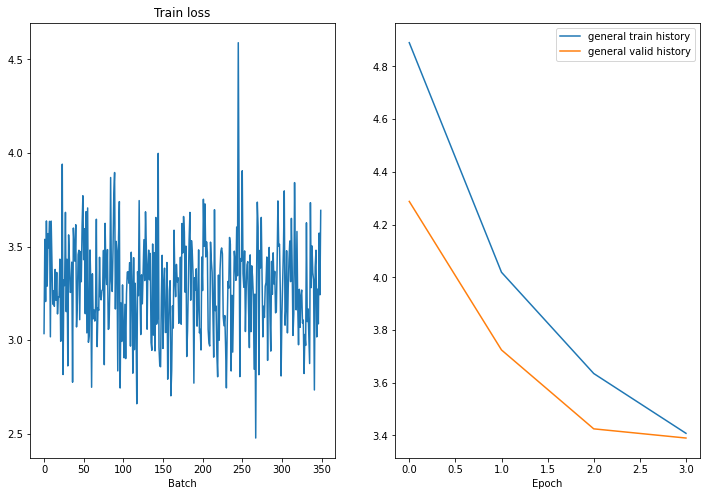

Epoch: 05 | Time: 0m 25s
	Train Loss: 3.283 | Train PPL:  26.656
	 Val. Loss: 3.286 |  Val. PPL:  26.731


In [42]:
%time

train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 5

teacher_forcing_ratio = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(network_attension, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(network_attension, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(network_attension.state_dict(), '/content/drive/MyDrive/best-val-model_attension.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [41]:
#torch.save(network_attension.state_dict(), '/content/drive/MyDrive/best-val-model_attension.pt')

In [44]:
print('Done!')

Done!


### Расчет bleu

In [45]:
model = CaptionNetWithAttension(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, cnn_feature_size= 2048, 
                                            dropout=DROPOUT, num_layers=NUM_LAYERS, bidirectional = BIDERECTIONAL).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/best-val-model_attension.pt', map_location=torch.device(device)))
model.to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CaptionNetWithAttension(
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
  (lstm): LSTM(2560, 512, batch_first=True, dropout=0.5)
  (embedding): Embedding(4613, 512)
  (dropout): Dropout(p=0.5, inplace=False)
  (logit): Linear(in_features=512, out_features=4613, bias=True)
  (attention): Attention(
    (attn): Linear(in_features=2560, out_features=2048, bias=True)
    (v): Linear(in_features=2048, out_features=1, bias=False)
  )
)

In [46]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

In [47]:
def cut_on_eos(tokens_iter):
    for token in tokens_iter:
        if token == '<eos>':
            break
        yield token

def remove_tech_tokens(tokens_iter, tokens_to_remove=['<sos>', '<unk>', '<pad>']):
    return [x for x in tokens_iter if x not in tokens_to_remove]

In [48]:
model.eval()
    
original_text = []
generated_text = []

with torch.no_grad():
    
    for i, batch in enumerate(valid_loader):

        # vectors_8x8 - в базовой части проекта не используется 
        vectors_8x8  = batch['vectors_8x8'].to(device)
        # vectors_neck == image_vectors   
        vectors_neck = batch['vectors_neck'].to(device)        
        captions_ix = batch['captions_ix'].to(device)
        sequence_length = batch['sequence_length']

        maxlen = max(sequence_length).item()

        batch_size = batch['vectors_neck'].shape[0]
  
        logits, hidden, cell = model(vectors_8x8, vectors_neck, captions_ix)
  
        preds = logits[:,:(maxlen-1),:]
        preds = preds.reshape(preds.shape[0]*preds.shape[1], preds.shape[2])
        
        # сдвигаем на токен вперед
        targets = captions_ix[:, 1:maxlen]
        targets = targets.reshape(targets.shape[0]*targets.shape[1])

        softmax = F.log_softmax(logits, -1)
        #get the highest predicted token from our predictions
        top_token = torch.argmax(softmax, -1)
        top_token = top_token[:, :maxlen]
 
        for _j in range(1,batch_size):
           sentence = cut_on_eos([data.index_to_words[x] for x in list(captions_ix[_j].cpu().numpy())])
           sentence = remove_tech_tokens(sentence)
           original_text.append(sentence)  
       
        for _j in range(1, batch_size):
            tokenlist = list(top_token[_j].cpu().numpy())
            tokenlist = tokenlist[:sequence_length[_j]]
            sentence = cut_on_eos([data.index_to_words[x] for x in tokenlist])
            sentence = remove_tech_tokens(sentence)
            generated_text.append(sentence)

        # очищаем cuda ---------------------------------------------------------
        if True:
            try:                
                logits.to(torch.device('cpu'))
                hidden.to(torch.device('cpu'))
                cell.to(torch.device('cpu')), 
                vectors_neck.to(torch.device('cpu'))
                vectors_8x8.to(torch.device('cpu'))
                captions_ix.to(torch.device('cpu'))
                preds.to(torch.device('cpu'))
                targets.to(torch.device('cpu'))
                softmax.to(torch.device('cpu'))
                
                del logits, hidden, cell, logits, vectors_8x8, vectors_neck, captions_ix, preds, targets,softmax

                torch.cuda.empty_cache()
            except:
                pass    
        # =---------------------------------------------------------------------
        #break

In [49]:
for i in range(15):
    
    # случайный индекс
    random_i = random.randint(0, len(original_text))

    print('Original: {}'.format(' '.join(original_text[random_i])))
    print('Generated: {}'.format(' '.join(generated_text[random_i])))
    print()

Original: two older women are preparing for a dinner
Generated: a men men sitting sitting a a cake

Original: a woman hitting a tennis ball on a tennis court
Generated: a tennis playing a tennis court at a tennis court

Original: a large stone fireplace with a mirror inside
Generated: a living living living with a living in a a

Original: a red and white truck driving on the road
Generated: a large truck white truck is down a side

Original: man standing next to barbecue with meat on plate
Generated: a is in to a a a

Original: three bowls filled with ice cream sitting on a counter
Generated: a of with a and on a table

Original: two green and yellow look motor cycles
Generated: a motorcycles motorcycle motorcycles motorcycle on on

Original: a table with a computer monitor keyboard mouse and speakers
Generated: a computer with a laptop and and and and a

Original: three children sit with empty plates in front of a cake
Generated: a men are on a cake of a of a table

Original: there ar

**Вывод:** Сеть очень быстро переобучается, поэтому количество эпох было уменьшено до 5. Видны небольшие заикания в генерируемом тексте. Каждый следующий токен в генерируемом тексте был получен спомощью "жадного" алгоритма. Поэтому, при генерации подписей к картинкам в дальнейшем,  будем сэмплировать следующий токен из распределения. Будем брать наиболее вероятный токен из 5 штук.

In [50]:
hypotheses = [text for text in generated_text]
list_of_references = [[text] for text in original_text]

In [51]:
chencherry = SmoothingFunction()
bleu = corpus_bleu(list_of_references, hypotheses,  smoothing_function=chencherry.method7)*100
print('BLEU {}'.format(round(bleu,2)))

BLEU 14.94


### Посмотрим на картинки

In [52]:
from torchvision.models.inception import Inception3
from warnings import warn


class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    
from torch.utils.model_zoo import load_url

def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [53]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
# from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:47: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [55]:
# индекс начала предложения
SOS_IDX = data.words_to_index[data.SOS]

In [56]:
# индекс конца предложения
EOS_IDX = data.words_to_index[data.EOS]

Функция генерации текста к картинкам.

In [57]:
def generate_caption_with_attn(model, image, caption_prefix=(SOS_IDX,), t=5, sample=True, max_len=25):

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
     
    with torch.no_grad():
        
        image_tensor = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
        vectors_8x8, vectors_neck, logits = inception(image_tensor[None])

        # несколько операций для картинок -----------------------------------------------
        vectors_neck = torch.Tensor(vectors_neck)       
        vectors_8x8 = torch.Tensor(vectors_8x8).squeeze(0).reshape(2048,64).permute(1,0)
        vectors_8x8 = vectors_8x8.unsqueeze(0)
        # --------------------------------------------------------------------------------

        vectors_neck = vectors_neck.to(device)
        vectors_8x8 = vectors_8x8.to(device)

        caption_prefix = list(caption_prefix)
        input = torch.tensor(caption_prefix).reshape(1,1)
        input = input.to(device)
  
        # слово за словом генерируем описание картинки
        for j in range(max_len):
            # print(j)

            last_token_index = input.squeeze(0).tolist()[-1]
             
            # -------------------------------------------------------------------------------------------------------------
            # 1. представляем caption_prefix в виде матрицы
            # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
            # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
            # 4. сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
            # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
            # 5. Добавляем новое слово в caption_prefix
            # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся
            # -------------------------------------------------------------------------------------------------------------
            
            logits, hidden, cell = model(vectors_8x8, vectors_neck, input)
            if j==0:
                logits = logits.unsqueeze(0)
            predictions = F.log_softmax(logits[0,-1,:], -1)
 
            argsort_token_list=torch.argsort(predictions, dim=-1, descending=True).tolist()
            argsort_token_list.remove(last_token_index)
            
            if not sample:
                # жадное сэмплирование -----------------------------------------
                #outputs = torch.argmax(predictions, -1)
                next_token_index = argsort_token_list[0]
                next_token = torch.tensor(next_token_index).unsqueeze(0).unsqueeze(0).to(device)
            else:
                 # сэмплирование из распределения -------------------------------

                 # список индексов из t наиболее вероятных токенов 
                 top_t_index = argsort_token_list[0:t]
                 # вероятности t токенов в распределении в полном словаре
                 prob = predictions[top_t_index]
                 # нормируем на 1 вероятности списка из t токенов
                 prob_norm = F.softmax(prob, -1).tolist()
                 # сэмплируем один токен из списка t токенов
                 next_token_index = random.choices(top_t_index, weights=prob_norm, k=1)[0]
                 next_token = torch.tensor(next_token_index).unsqueeze(0).unsqueeze(0).to(device)
                 # --------------------------------------------------------------
            if next_token_index == EOS_IDX:
                break
            input = torch.cat([input, next_token], dim=-1)

                        
        sentence = cut_on_eos([data.index_to_words[x] for x in input[0].cpu().tolist()])
        sentence = remove_tech_tokens(sentence)
        sentence = ' '.join(sentence)

    #print(sentence)
    return sentence

In [58]:
from matplotlib import pyplot as plt
#from scipy.misc import imresize
from skimage.transform import resize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img_skate.jpg
img_skate = plt.imread('img_skate.jpg')
#img = imresize(img, (299, 299)).astype('float32') / 255.
img_skate = resize(img_skate, (299, 299, 3)).astype('float32') #/255.



--2022-07-19 10:17:45--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2022-07-19 10:17:45--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img_skate.jpg’

img_skate.jpg       100%[===================>]  53.45K  --.-KB/s    in 0.01s   

2022-07-19 10:17:45 (4.92 MB/s) - ‘img_skate.jpg’ 

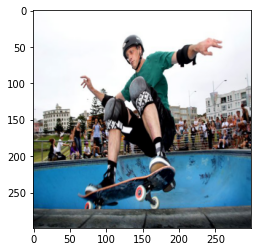

In [59]:
plt.imshow(img_skate)

In [60]:
for i in range(10):
    print(generate_caption_with_attn(model, img_skate, t=5, sample=True ))

a skateboarder jumping on top of a skateboard
a young boy riding a skateboard at the air
a man jumping a kite on a skateboard
the young girl is jumping a kite in the air
a man is riding a kite in a kite
a young boy is in the air while holding a frisbee
a woman jumping in the air is riding a kite
a man jumping on a skateboard while a kite
the man is on the air while a kite in his hand
a young boy in a skate board on a skateboard


Неплохо:

- a skateboarder jumping on top of a skateboard
- a young boy riding a skateboard at the air

--2022-07-19 10:18:05--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2022-07-19 10:18:05--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img_cat_and_dog.jpg’

img_cat_and_dog.jpg 100%[===================>] 104.37K   505KB/s    in 0.2s    

2022-07-19 10:18:06 (505 KB/s) - ‘img_cat_and_dog.jpg’ saved [106870/106870]



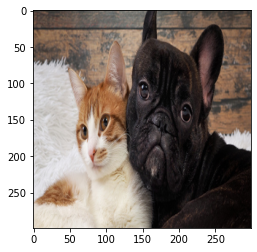

In [61]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img_cat_and_dog.jpg
img_cat_and_dog = plt.imread('img_cat_and_dog.jpg')
#img = imresize(img, (299, 299)).astype('float32') / 255.
img_cat_and_dog = resize(img_cat_and_dog, (299, 299, 3)).astype('float32')

plt.imshow(img_cat_and_dog)
plt.show()

In [62]:
for i in range(10):
    print(generate_caption_with_attn(model, img_cat_and_dog, t=5, sample=True ))

a cat laying in front of a window with two stuffed bears
a dog is sitting on the ground with a dog in a window
a dog sitting on a wooden chair while holding the dog
a dog sitting next to a dog in a window
a cat sitting on a bed while holding a white dog
an image of a cat laying on the ground
a dog on a small couch with a book
a small brown cat sleeping on the ground next to a window
the cat is sleeping on top of a bed
a dog and two stuffed animal in the background


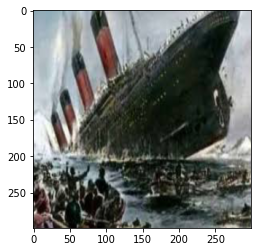

In [65]:
img_titanik = plt.imread('/content/titanik.jpg')
#img = imresize(img, (299, 299)).astype('float32') / 255.
img_titanik = resize(img_titanik, (299, 299, 3)).astype('float32')
plt.imshow(img_titanik)
plt.show()

In [66]:
for i in range(10):
    print(generate_caption_with_attn(model, img_titanik, t=5, sample=True ))

the beach is on a boat with a surfboard and a boat
a man is on the beach in the air with a surfboard
the surfer riding a beach with a surf board
an orange boat is riding the beach with a surfboard
a man on a beach in the water
there is a small boat in the shore
a person riding a surf board next to a boat
a man on a beach next to a boat in the ocean
a man with some birds are on a surfboard in it
a boat is standing in the water is holding a boat


'*a man on a beach next to a boat in the ocean*' -  это уже почти нормально))))

# Итоги по вариативной части:

Построен полный pipeline рабочей модели для формирования подписей к картинкам, а именно: 

- Подготовлен датасет (производная от COCO) размером 6000 изображений и получены эмбеддинги картинок при помощи предобученной сети Inseption.

- сконструирована и обучена RNN сеть с блоком Bahdanau Attension

- По сравнению с обычной RNN моделью подписи к картинкам стали короче, и более "осмысленными". Ближе к естественному языку. Например, в картинке со скэйтбордом вполне себе неплохие фразы '*a skateboarder jumping on top of a skateboard*' и '*a young boy riding a skateboard at the air*'

- как,неожиданно оказалось, показатель bleu можно легко "поднять" увеличив количество эпох обучения....НО! при этом подписи к картинкам стали обрываться практически сразу на втором генерируемом токене. Также подписи обрывались, если использовалась biderectional lstm))))